In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib
import time
import numpy as np
%matplotlib inline

import pandas as pd
pd.options.display.max_colwidth = 300
pd.options.display.max_columns = 100


In [3]:
#Model File Directory
WORK_DIR = '/var/spark/ml_files/'

#Label Keys
LABEL = "success"

MODEL_TYPE = "ML-ECO"





In [5]:
from cassandra.cluster import Cluster
cassandra_endpoint = '10.62.1.118'
cluster = Cluster([cassandra_endpoint])


In [6]:
TRAINING_DATA_PATH = WORK_DIR + 'eco_2019_06.csv'
eco = pd.read_csv(TRAINING_DATA_PATH)
eco.shape

/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (6,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(136989, 48)

In [7]:
date_increment_bin_dict = None
added_years_bin_dict = None

DATE_INCREMENT_BIN_PATH = WORK_DIR + 'date_increment_bin_2019_Q1.csv'
ADDED_YEARS_BIN_PATH = WORK_DIR + 'added_years_bin_2019_Q1.csv'

if DATE_INCREMENT_BIN_PATH:
    date_increment_bin = pd.read_csv(DATE_INCREMENT_BIN_PATH)
    date_increment_bin.drop(columns=['Unnamed: 0'], inplace=True)
    date_increment_bin['bin'] = date_increment_bin['bin'].apply(str).str.replace('.0', '', regex=False)
    date_increment_bin['date_increment'] = date_increment_bin['date_increment'].apply(str).str.replace('.0', '', regex=False)
    date_increment_bin_dict = date_increment_bin.set_index(['bin', 'date_increment'])['success_rate'].T.to_dict()

    
if  ADDED_YEARS_BIN_PATH:
    added_years_bin = pd.read_csv(ADDED_YEARS_BIN_PATH)
    added_years_bin.drop(columns=['Unnamed: 0'], inplace=True)
    added_years_bin['bin'] = added_years_bin['bin'].apply(str).str.replace('.0', '', regex=False)
    added_years_bin['added_expiry_years'] = added_years_bin['added_expiry_years'].apply(str).str.replace('.0', '', regex=False)
    added_years_bin_dict = added_years_bin.set_index(['bin', 'added_expiry_years'])['success_rate'].T.to_dict()



In [8]:
eco = eco[~eco['date_increment'].isna()]
eco = eco[~eco['added_expiry_years'].isna()]
eco.loc[eco.added_expiry_years == 'STALE', 'added_expiry_years'] = 0
eco['cc_expiration_date'] = eco['cc_expiration_date'].apply(str)
eco.shape

(115726, 48)

In [9]:
original_size = len(eco)
fail_size = eco[LABEL].value_counts(normalize=True)[0.0]
success_size =  eco[LABEL].value_counts(normalize=True)[1.0]

In [10]:
#import for training
import numpy as np
from sklearn import cross_validation
from sklearn import metrics
from sklearn.model_selection import cross_val_score

from sklearn import linear_model
from sklearn import tree
from sklearn import cross_validation
from sklearn import ensemble
from sklearn import linear_model
from sklearn import svm
from sklearn.dummy import DummyClassifier
# from sklearn.model_selection import GridSearchCV
from spark_sklearn import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier

# from src.web.utils import PreProcessing
from src.web.preprocessing import PreProcessing
from src.web.encoder import EnhancedLeaveOneOutEncoder
from src.web.train_util import *

/opt/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
INPUT_FEATURES = {
            "billing_country": {
                "type": "string"
            },
            "bin": {
                "type": "string"
            },
            "card_brand": {
                "type": "string"
            },
            "card_category": {
                "type": "string"
            },
            "card_class": {
                "type": "string"
            },
            "card_usage": {
                "type": "string"
            },
            "cc_expiration_date": {
                "type": "string"
            },
            "day_of_month": {
                "type": "integer"
            },
            "funding_source": {
                "type": "string"
            },
            "issuer_country": {
                "type": "string"
            },
            "payment_amount_usd": {
                "type": "number"
            },
            "payment_currency": {
                "type": "string"
            },
            "payment_method_id": {
                "type": "string"
            },
            "transaction_date_in_string": {
                "type": "string"
            },
            "bank_name": {
                "type": "string"
            }
        }

In [12]:
FEATURES_CAT = ["card_brand", "funding_source", "card_category", "card_class", "card_usage", "issuer_country", "day_of_month", 
                "payment_method_id", "bin",  "payment_currency", "date_increment", "bank_name", "merchant_number", 
                "payment_service_id"]


FEATURES_FLOAT = ['bin', 'date_increment']
FEATURES_NUM = [] 
FEATURES_NUM_CALCULATED = [] 

FEATURES_NUM_ENCODED = ['expired_years_diff', 'years_over', "date_inc_bin", "add_expiry_years_bin"]

FEATURES_ENCODED = [ 'week_of_month', 'day_of_week', 'month', 'cc_month', 'is_expired'] + FEATURES_NUM_CALCULATED


FEATURES = FEATURES_CAT + FEATURES_ENCODED


# from sklearn.model_selection import GridSearchCV
from spark_sklearn import GridSearchCV


from src.web.preprocessing import PreProcessing
from src.web.preprocessing import make_pipeline
from sklearn.preprocessing import Imputer

# FIELDS = FEATURES_CAT + FEATURES_NUM + ['transaction_date_in_string', 'cc_expiration_date', 'failed_attempt_date', 'failed_cc_expiration_date'] + FEATURES_NUM_ENCODED + FEATURES_NUM_CALCULATED
# FIELDS = FEATURES_CAT + FEATURES_NUM + ['transaction_date_in_string', 'cc_expiration_date', 'billing_country'] + FEATURES_NUM_ENCODED + FEATURES_NUM_CALCULATED
FIELDS = FEATURES_CAT + FEATURES_NUM + ['transaction_date_in_string', 'cc_expiration_date', 'billing_country']

# df_decline_type = pd.read_csv(WORK_DIR + 'Decline_Type.csv')

features_dict = {'LABEL': LABEL, 'FIELDS': FIELDS ,'FEATURES_CAT': FEATURES_CAT, 'FEATURES_NUM':FEATURES_NUM, 'FEATURES_ENCODED':FEATURES_ENCODED, 'FEATURES_NUM_ENCODED':FEATURES_NUM_ENCODED, 'FEATURES_NUM_CALCULATED':FEATURES_NUM_CALCULATED, 'FEATURES_FLOAT': FEATURES_FLOAT}
features_dict_key = 'preprocessing__features_dict'
features_dict['df_bin_profile'] = None
# features_dict['df_decline_type'] = df_decline_type
# features_dict['df_eco_bin'] = eco_bin_profile

features_dict['date_increment_bin_dict'] = date_increment_bin_dict
features_dict['added_years_bin_dict'] = added_years_bin_dict



--------------------
(90, 17)
(90,)
(10, 17)
(10,)
df_bin_profile is NONE
Best Retry preprocessing pipeline ... 
training xgb ....... 
In EnhancedPipeline fit_predict ...
self.features_encoded: ['week_of_month', 'day_of_week', 'month', 'cc_month', 'is_expired']


/var/spark/jupyter-notebooks/src/web/preprocessing.py:231: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].fillna('').astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:237: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[WEEK_OF_MONTH] = df[TXN_DATE_IN_STR].apply(week_of_month)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:240: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

# Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["date_inc_bin"] = df.apply(self.eco_bin_util.date_inc_bin, axis=1)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["added_expiry_years"] = df["expired_years_diff"] + df["years_over"]
/var/spark/jupyter-notebooks/src/web/preprocessing.py:332: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

self.features_all:  ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'day_of_month', 'payment_method_id', 'bin', 'payment_currency', 'date_increment', 'bank_name', 'merchant_number', 'payment_service_id', 'week_of_month', 'day_of_week', 'month', 'cc_month', 'is_expired', 'expired_years_diff', 'years_over', 'date_inc_bin', 'add_expiry_years_bin']
In fit, self.features_cat_and_encoded: ['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'day_of_month', 'payment_method_id', 'bin', 'payment_currency', 'date_increment', 'bank_name', 'merchant_number', 'payment_service_id', 'week_of_month', 'day_of_week', 'month', 'cc_month', 'is_expired']
['card_brand', 'funding_source', 'card_category', 'card_class', 'card_usage', 'issuer_country', 'day_of_month', 'payment_method_id', 'bin', 'payment_currency', 'date_increment', 'bank_name', 'merchant_number', 'payment_service_id', 'week_of_month', 'day_of_week', 'mo

/var/spark/jupyter-notebooks/src/web/preprocessing.py:360: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["merchant_number"] = df.apply(self.convert_mid, axis=1)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:231: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feat] = df[feat].fillna('').astype(str).str.replace('.0', '', regex=False)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:237: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

# Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["years_over"] = df.apply(years_over, axis=1)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["date_inc_bin"] = df.apply(self.eco_bin_util.date_inc_bin, axis=1)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:334: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

# transform_time: 0.552269458770752
[06:10:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[06:10:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[06:10:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[06:10:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[06:10:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[06:10:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 2 pruned nodes, max_depth=1
[06:10:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[06:10:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, 

[06:10:09] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[06:10:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[06:10:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[06:10:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[06:10:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[06:10:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[06:10:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[06:10:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[06:10:10] /workspace/sr

/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/var/spark/jupyter-notebooks/src/web/preprocessing.py:360: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["merchant_number"] = df.apply(self.convert_mid, axis=1)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:231: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  

# Finish handle_feat_encoded.


/var/spark/jupyter-notebooks/src/web/preprocessing.py:321: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["expired_years_diff"] = df.apply(expired_years_diff, axis=1)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:324: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["years_over"] = df.apply(years_over, axis=1)
/var/spark/jupyter-notebooks/src/web/preprocessing.py:327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

# transform_time: 0.12689638137817383
# training time: 8.60064435005188
x_train:    card_brand funding_source   card_category card_class  \
18       Visa         Credit   Visa Platinum   Consumer   
30       Visa          Debit    Visa Classic   Consumer   
73       Visa         Credit   Visa Platinum   Consumer   
33       Visa         Credit  Visa Signature   Consumer   
90       Visa          Debit   Visa Platinum   Consumer   

                                            card_usage issuer_country  \
18  Credit - True credit (No PIN/Signature capability)             AR   
30      Debit - NON USA Consumer Debit - No Pin Access             TH   
73  Credit - True credit (No PIN/Signature capability)             IN   
33  Credit - True credit (No PIN/Signature capability)             EC   
90      Debit - NON USA Consumer Debit - No Pin Access             SG   

    day_of_month payment_method_id     bin payment_currency date_increment  \
18             4              Visa  425821     

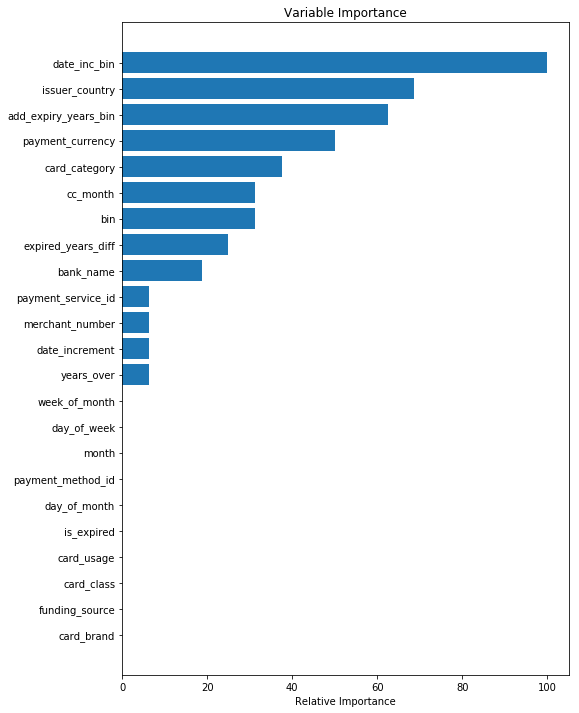

In [26]:
""" Train the model"""

#XGBoost Classifier
from xgboost import XGBClassifier
from src.web.preprocessing import *
from src.web.preprocessing import PreProcessing 
from src.web.train_util import *
classifier = XGBClassifier

tuned_parameters = None

best_parameters = {
              'objective': 'binary:logistic',
              'learning_rate': 0.13, #so called `eta` value
              'max_depth': 10,
              'min_child_weight': 6,
              'silent': 0,
              'subsample': 0.8,
              'colsample_bytree': 0.7,
              'n_estimators': 1000,
              'missing':-999,
              'seed': 1337,
              'eval_metric': 'map',
              'gamma': 2  }

model_file = ''
model_id = 'ML-ECO-2'
version = get_latest_version(model_id, MODEL_TYPE) + 1
model_name = model_id + '.' + str(version)
features_dict['eval_metric'] = 'map'
xgb_clf, result_d = build_and_train(eco, classifier, tuned_parameters, 'xgbclassifier', model_file, best_param=best_parameters, features_dict=features_dict)
model_file, model_file_name = write_model(xgb_clf, model_name)
print("model_file is generated: ", model_file)
print("result_dict: ", result_d)


In [14]:
result_d

{'hyper_params': {'objective': 'binary:logistic',
  'learning_rate': 0.13,
  'max_depth': 10,
  'min_child_weight': 6,
  'silent': 0,
  'subsample': 0.8,
  'colsample_bytree': 0.7,
  'n_estimators': 1000,
  'missing': -999,
  'seed': 1337,
  'eval_metric': 'map',
  'gamma': 2},
 'training_time': 417.9893136024475,
 'accuracy_dummy': 0.8219994815518881,
 'train_accuracy': 0.9577640586444942,
 'test_accuracy': 0.8836948068780783,
 'train_class_report': '             precision    recall  f1-score   support\n\n          0       0.97      0.98      0.97     85787\n          1       0.89      0.87      0.88     18366\n\navg / total       0.96      0.96      0.96    104153\n',
 'test_class_report': '             precision    recall  f1-score   support\n\n          0       0.92      0.94      0.93      9513\n          1       0.68      0.64      0.66      2060\n\navg / total       0.88      0.88      0.88     11573\n',
 'feature_importance_columns': "Index(['month', 'is_expired', 'payment_meth

In [23]:
# """Upload model to Nexus repo and insert the model info into Cassandra table"""
# import json

# # start_date = '2018-01-01'
# start_date = '2019-01-01'

# end_date = '2019-05-31'

# try:
#     repo_path = upload_artifact(model_file_name)
#     preprocess_repo_path = handle_preprocessing_file(model_id, version)
#     size_desc = str(", original size: %s (fail: %s, success: %s), balanced_size: %s" % (original_size, fail_size, success_size, original_size))
#     desc = '{}_{}_for_eco model with date_inc_bin and added_years_bin. {}'.format(start_date, end_date, size_desc)
#     hyper_params = result_d.pop('hyper_params', None)
#     extended_att = {"preprocess_repo_path": preprocess_repo_path, "input_features": INPUT_FEATURES}
#     insert_model_info(model_id, version, repo_path, desc=desc, model_type=MODEL_TYPE,eval_metrics=json.dumps(result_d), 
#                       hyper_parameter=json.dumps(hyper_params), extended_att=json.dumps(extended_att), features_dict=features_dict)
    
# except:
#     if not hyper_params:
#         result_d['hyper_params'] = hyper_params 

http://10.48.48.10/nexus/content/repositories/foundationreleases/com/digitalriver/prediction-service/ML-ECOTEST/1.1/ML-ECOTEST-1.1.pkl
[com.digitalriver.prediction-service:ML-ECOTEST:1.1::pkl]
http://10.48.48.10/nexus/content/repositories/foundationreleases/com/digitalriver/prediction-service/ML-ECOTEST/1_1_preprocessing/ML-ECOTEST-1_1_preprocessing.py
[com.digitalriver.prediction-service:ML-ECOTEST:1_1_preprocessing::py]
Model ML-ECOTEST-1 version 1 is inserted into model repo


The following files were uploaded to repository foundationreleases
The following files were uploaded to repository foundationreleases
